## Title? Discussion about the KL divergence ??


#### To be included in section II?
In the above, we have considered different scenarios, with different 'OOD' data and considering the same training objective: the reverse Kullback-Leibler divergence. But what does this "objective" actually mean ? 

In many different settings (such as the Prior's network approach), one might be interested in learning an approximate probability distribution rather a point estimate, to get a fine level of approximation. Indeed, in the example presented above, we strongly prefer understanding how confident the prior network is in its predictions rather than simply learning the "right class"(the former implying the latter). In this context, the question is how to "learn/approximate a distribution", or equivalently "how to compare two probability distributions"?

Oftentimes, one would like to define a distance to compare two elements from a metric space. This is often trivial in a simple euclidian space $\mathbb{R}^p$, where distances are all equivalent.
When it comes to probability distributions, there is no clear choice of "distance " and one option is to use the Kullback-Leibler divergence ($DKL(p,q)=\int p\cdot log(\frac{p}{q})$). Let $p$ be the target distribution (the one to approximate) and $q$ the approximation (i.e variational, or in our case, the distribution parametrized by the prior Network). One problem is that, in general, $KL(p,q) \neq KL(q,p)$: the "_Forward KL divergence(KL)_" and "_Reverse KL divergence (RKL)_" might differ.

We recall that in the Prior Network settings we consider $x \in \mathbb{R}^2$. The prior network models $p(\mu|x, \theta)=Dir(\mu|\alpha) \,, \alpha=f(x,\theta))$, where $\theta$ are the Prior network's parameters. In short, the output of the network represents the concentration parameter of a Dirichlet distribution and ideally, we would like this Dirichlet distribution to "look like" the target distribution. Therefore, we use the Kullback-Leibler divergence (in either one of its form) as the training objective.

However, depending on the distributions considered (in our case, distributions conditioned on the data-henceforth depending on the data), choosing one form or the other might yield different results. 

In line with Andrey Malinin's theory, we show that training a prior network using _forward_ or _reverse_ Kullback-Leibler Divergence will, under certain circumstances, yield different results.
#### End of that part 

#### Motivation
In the above, we used the Diverse KL objective between the target distribution and the distribution modelled by the prior network. However, choosing between the reverse of forward KL objective is not trivial and can, under certain circumstances yield different models. This choice is a design choice that any user should be aware of, and is the main theme of Andrey Malinin's follow-up paper: _Reverse KL-Divergence Training of Prior Networks: Improved Uncertainty and Adversarial Robustness_ [(arxiv)](https://arxiv.org/pdf/1905.13472.pdf).

In the following, we do not include any "OOD" data point and show that:
* When the **data points are from distinct classes and strictly not overlapping**, the forward and reverse kl objective result in similar models.
* Whenever, the **dataset presents overlap**, the training objectives result in models with different behaviors, that we analyze theoretically and experimentally. 

#### Experimental setup
* For each experiment conducted, the network is trained for a number of epochs ```n_epochs``` and using either the forward or the reverse KL divergence (```reverse``` or ```forward``` mode) described earlier.

* First, we train the network on a data set presenting three distinct classes and using both KL and Forward trainig objectives. We display the training loss and the decision surface obtained. We refer to the appendix notebook for a further analysis of the training curriculum. 


* Then, we create a dataset presenting data overlap, train the network with the two objectives and in addition to the training loss and decisoin surface, we add the following:
    * **Plot of the network's output during the training process**: each training point is a tuple $\{x, \hat{\alpha}_x \}$ where $\hat{\alpha}$ is in the set $\{target_1, target_2, target_3 \} = \{(101, 1, 1), (1, 101, 1), (1, 1, 101) \}$. For all the training points such that $\hat{\alpha}_x \subset \{target_i\} \,,i=\{1,2,3\}$, we display (in column $i$) the three output coordinates of the network during the training curriculum. For instance, the second column-third row corresponds to the evolution of the third coordinates of the network's output $f(x;\theta)_3$ for the training points such that $\hat{\alpha}_x \subset \{target_2\}$.
    * **Histogram of the network's output distribution**: once the model is trained, we consider all the points in the dataset and the corresponding network output $f(x;\theta)$. Similarly, column i-row j correspond to the distribution (histogram plot) of $f(x;\theta)_j$ for the points $x$ for which $\hat{\alpha}_x \subset \{target_i\}$.
    * **The precision parameter of the network** ( $\sum_i f(x;\theta)_i$ ) during the training curriculum.


In [3]:
#Load the setup
import matplotlib.pyplot as plt
%run -i 'exp_alphas.py'
#print(args)
#args[renderer]='chrome' #uncomment for interactive plots. Other choices as well.

Loaded the experimental setup


###  When the data presents well separated clusters strictly not overlapping, Forward or Reverse objectives yield similar results

In [4]:
args['mode'] = 'forward'
#Output: trained model and a dictionnary containing variables saved during the training
model, tracks = main(args, data)

Training for 1000 epochs, using forward


In [5]:
args['mode'] = 'reverse'
model, tracks = main(args, data)

Training for 1000 epochs, using reverse


 Both training losses converge towards, and despite decision surfaces showing slight differences, this does not seem to have impactful consequences on the level of confidence in predictions.
Ultimately, we can conclude that despite slight differences, the two training processes yield similar results for the simple settings considered: **data points from distinct classes and strictly not overlapping**.

_Please refer to the appendix notebook for further analysis._

#### Class overlap (and high data uncertainty) show that the different training objectives result in different distributions

Let's now imagine one more scenario in which our data presents some overlap: several patients with really similar age and BMI were (successfully) administered  three treatments. When an expert (or at least a good algorithm) is facing such data (see below), he should probably not being confident in proposing a treatment to a new patient presenting features for which any of the treatment could succeed (or fail). And since the expert has seen many similar data points, he should certainly not classify this new patient as out of distribution. The desired behavior would rather be to be confident about not knowing. 

In this context, the KL objective trains the network to behave like an arithmetic mixture of Dirichlet distributions which yields undesirable behaviors, whereas the RKL objective urges the network to behave like a geometric mixture of Dirichlet-inducing a more suitable behavior (see below):

In the following, we:
* Create a new synthetic data set with overlapping classes (and no OOD data)
* Train two networks with the exact same configuration except from the training objective and observe the training curriculum
* We then extend the theoretical reasons why the RKL is more appropriate than the KL objective and experimentally verify the theory advanced

**Remark:**
* In the following we interchangeably use "Reverse Network", "Network trained with the RKL objective", ... model" and similarly for "Forward network".

#### 1. Training diagnostic

In [6]:
from utils.data import create_data
from utils.plot import plot_training_data
#Let's change the data so that the overlap is more important. 
scale = 1.1
overlap = mog_three_in_distribution = {
    'gaussians_means': scale * np.array([
        [0., 2.],
        [-np.sqrt(3), -1.],
        [np.sqrt(3), -1.]]),
    'gaussians_covariances': np.array([
        [[2.0, 0], [0, 2.0]],
        [[2.0, 0], [0, 2.0]],
        [[2.0, 0], [0, 2.0]],
    ]),
    'n_samples_per_gaussian': np.array(
        [100, 100, 100]),
    'out_of_distribution': np.array(
        [False, False, False])
}
#shuffle = True 
data = create_data([
    create_data_mixture_of_gaussians],
    [mog_three_in_distribution])#, shuffle=shuffle)

plot_training_data(data['samples'], data['targets'])

Training for 1000 epochs, using forward


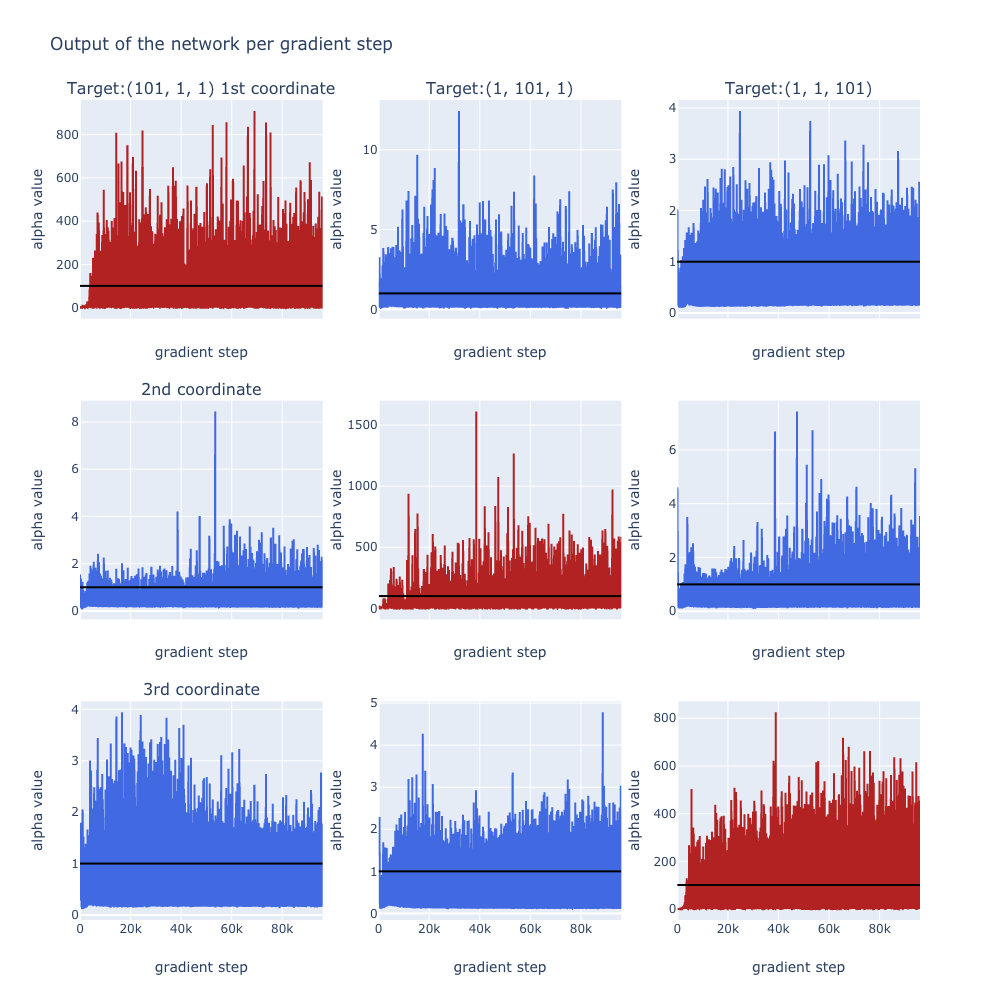

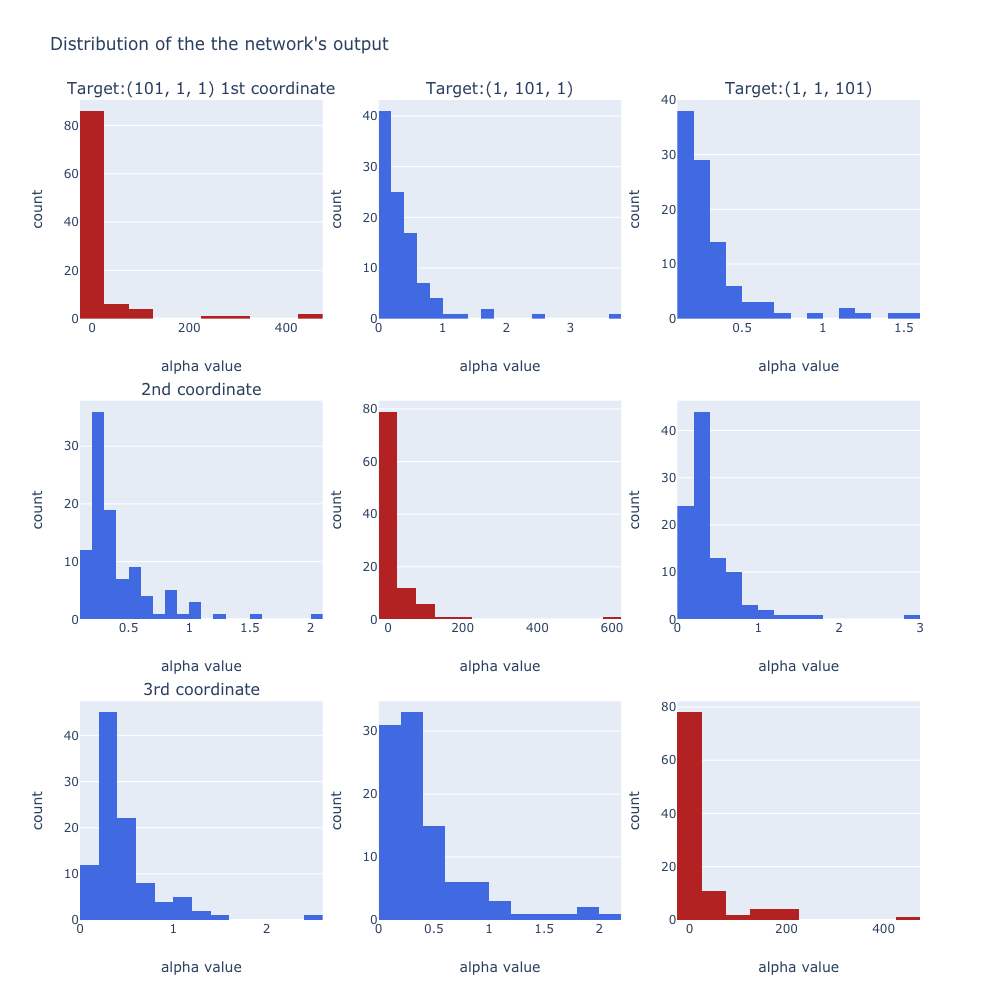

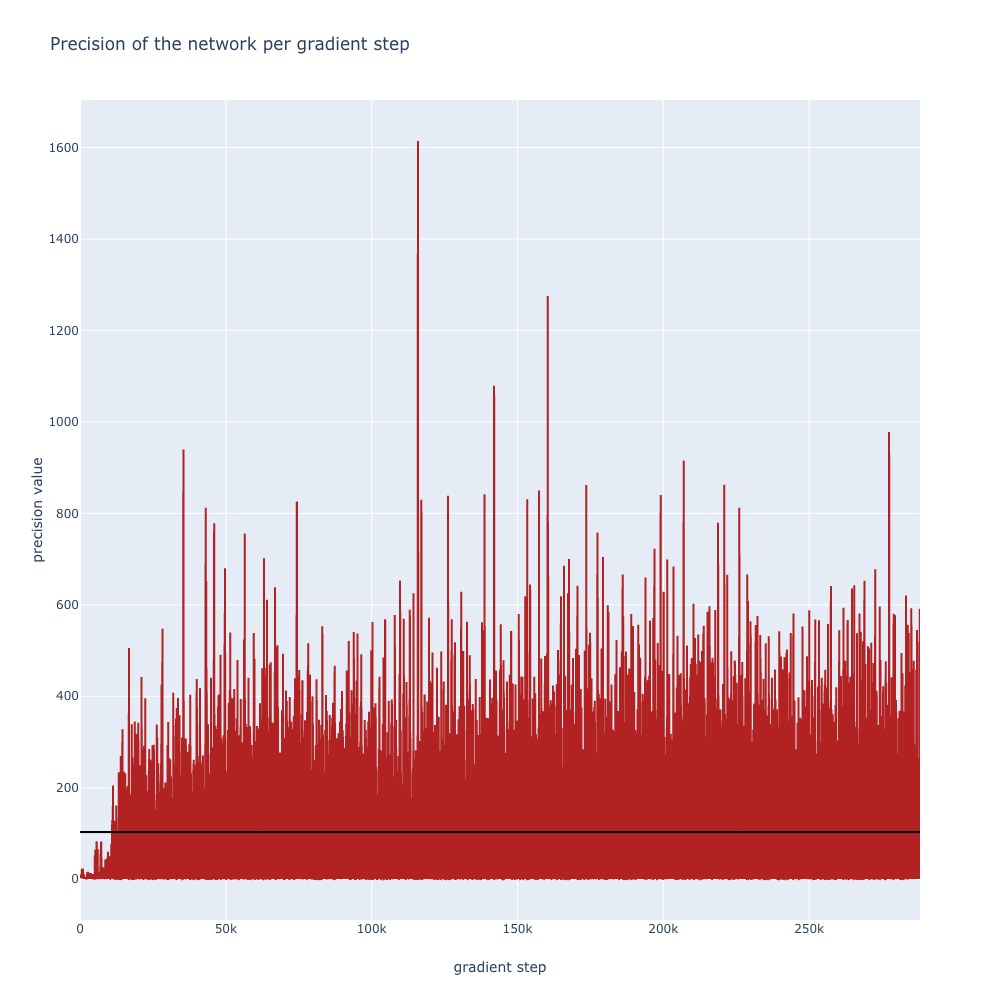

In [7]:
args['mode'] = 'forward'
args['plot_all'] = True
model_fwd, tracks_fwd = main(args, data)

Training for 1000 epochs, using reverse


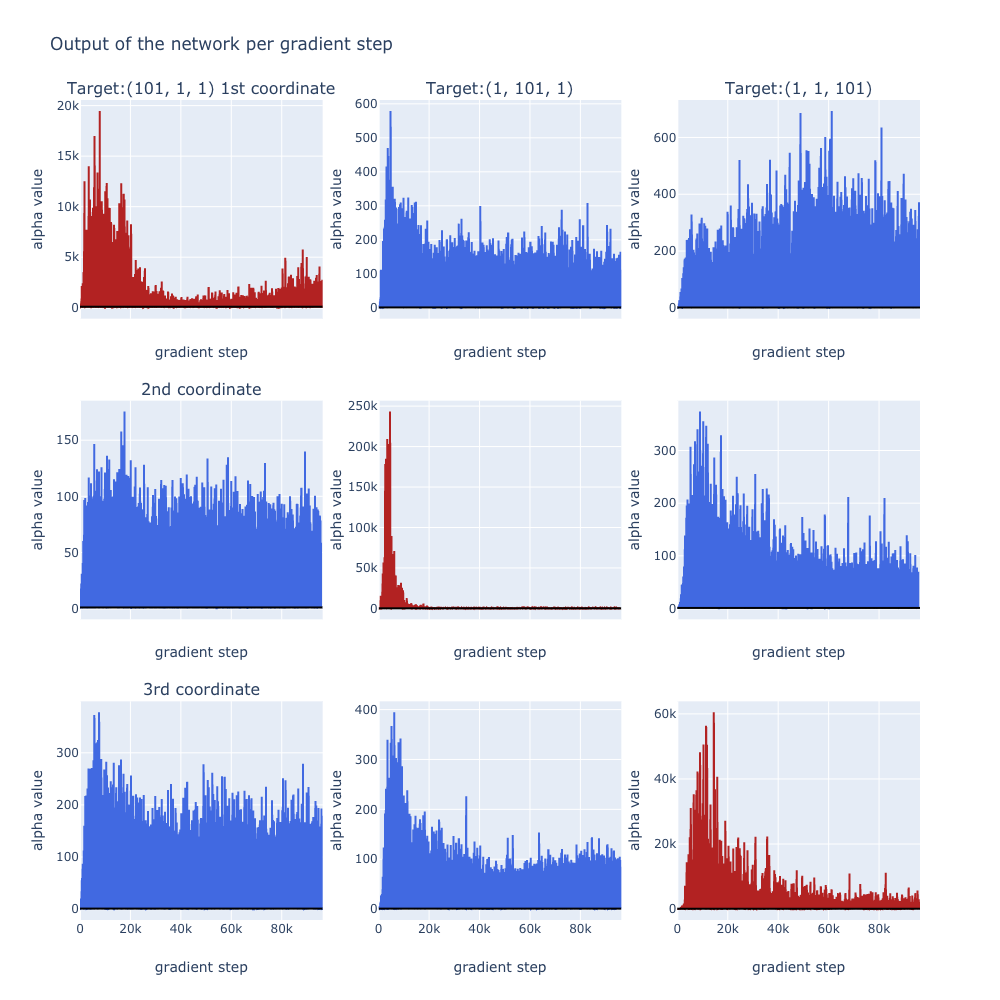

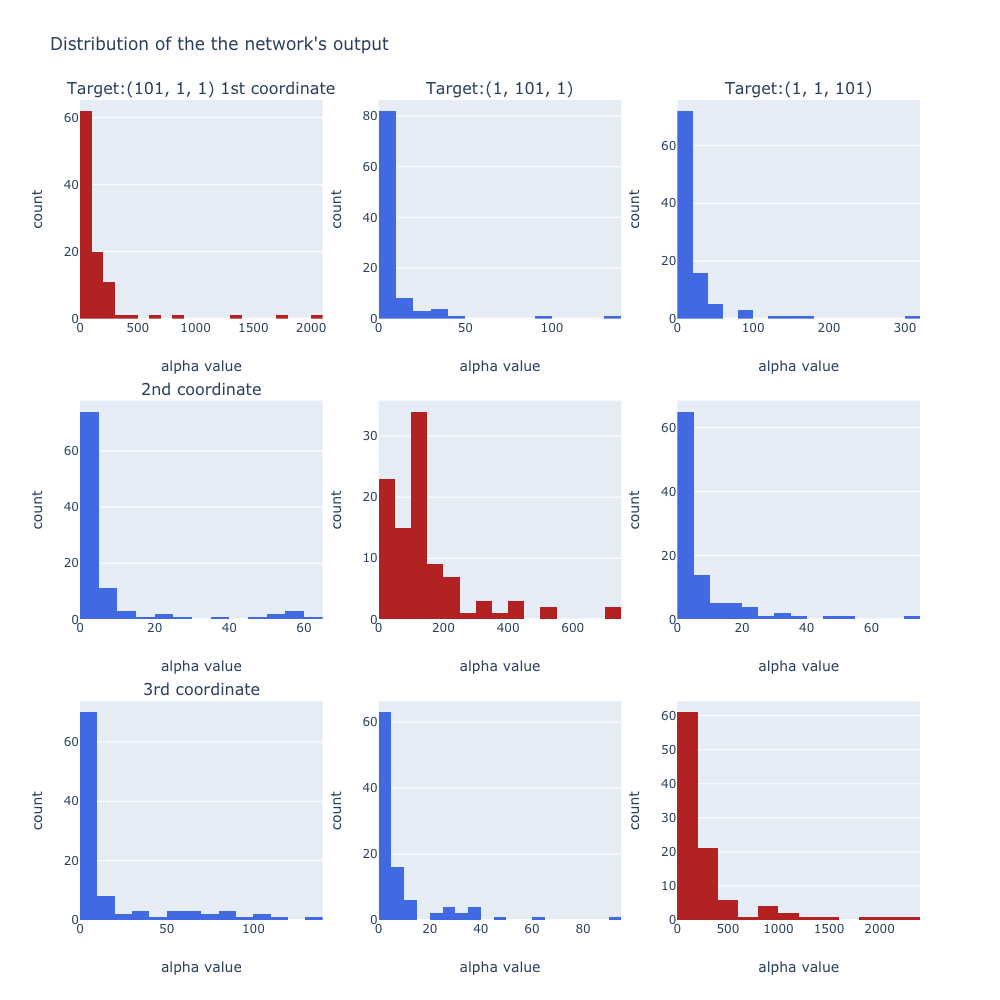

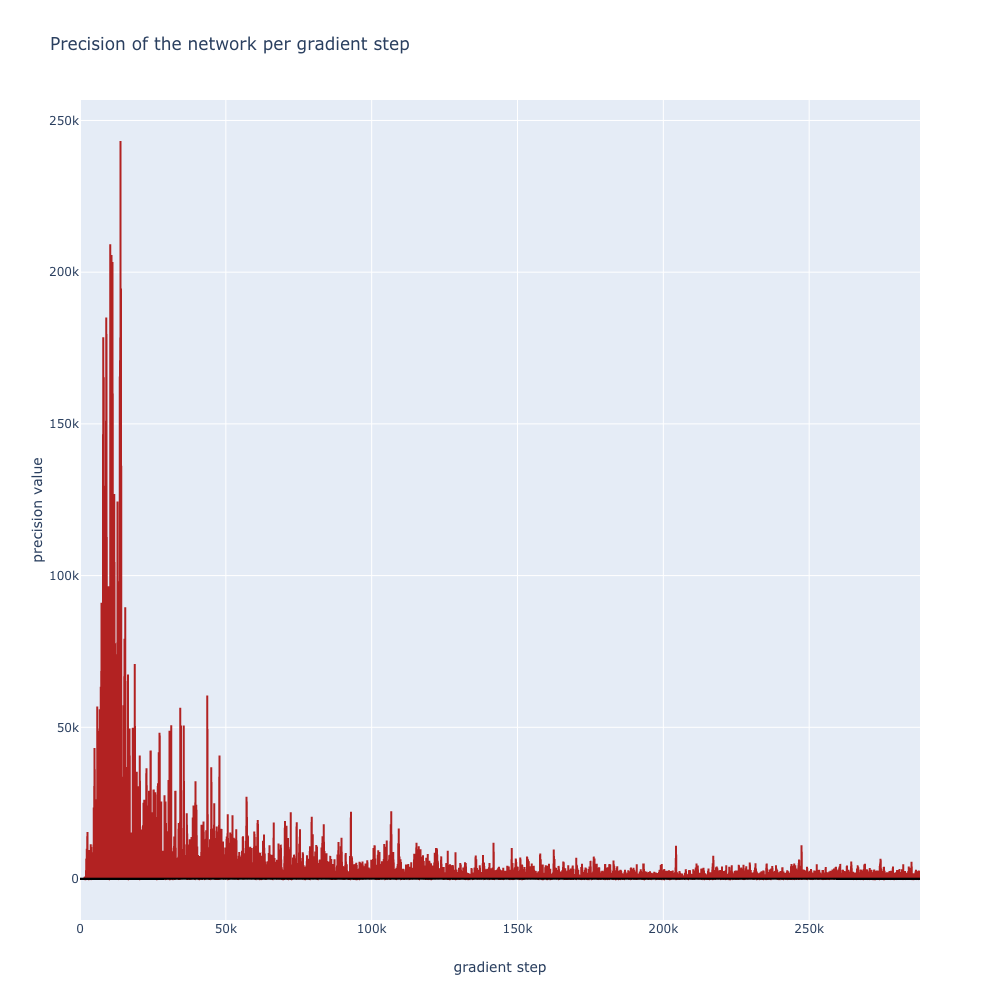

In [8]:
args['mode'] = 'reverse'
args['plot_all'] = True
model_rev ,tracks_rev  = main(args,data)

The two training losses displayed have oscillating patterns and it seems that there is a trend towards convergence. The oscillations of the "RKL network" are nevertheless more important than the ones from the "KL" which looks smoother. 
Intuitively, we hypothesize that the KL model makes "smaller errors". However, it could also mean that even when points are in *an overlapping area* (at the center of the grid for instance), the model outputs values that are less extreme and centered around the right mode.

- **With the KL objective**: The inference step provides distributions relatively close to the target one: the non-diagonal histograms plots are in a $0-2$ range and the diagonal plots display a distribution centered around higher values. 

- **With the RKL objective**: the loss and trace plots are highly oscillating and the non-diagonal terms of the histograms now appear on a $0-500$ while the diagonal terms range from 0 to several thousands. All the traces are pushed towards higher values. We might naively diagnose a poor training behavior.

One question arises: would we expect or want the network to have a behavior similar to the one of the target distribution in this specific context? 

Let's consider a point $x \in \mathbb{R}^2$ in one area where the data is overlapping, for instance $x = (0,0)$ (as a proxy for the region where the data is highly overlapping). 
Let's recall that $\alpha = f(x;\theta)$ represents the concentration parameter of a (3 dimensional) Dirichlet distribution, defined on the 3d simplex (its behavior can and is most of the time visualized on a simplex). In the case of high overlap, the desiderata would be to obtain a Dirichlet ditribution $p(\mu|x, \hat{\theta})$ centered on the center of the simplex.

_Remarks_:
* *For a reminder about the Dirichlet distribution [(CMU) Professor Xing's notes](https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/dirichlet.pdf) is an excellent resource*. 

#### 2. Theoretical behavior
The following section is adapted from "_Reverse KL-Divergence Training of Prior Networks:
Improved Uncertainty and Adversarial Robustness_" [(arxiv)](https://arxiv.org/pdf/1905.13472.pdf)

Let us define the **forward KL objective**: $$l(\theta, y, x) = \sum_{c=1}^{K} \mathbb{1}_{y=c} KL(p(\mu|\alpha_x) || p(\mu|f(x;\theta))$$

We denote $\hat{p}(x,y)$ the empirical distribution of the data and we now consider the expectation of the loss with respect to this empirical distribution:
$$\mathbb{E}_{\hat p}[l(\theta, y, x)] = \mathbb{E}_{\hat p} [KL( \sum_{c=1}^{K} \hat{p}(x,y) p(\mu|\alpha_x) || p(\mu|f(x;\theta))] + constant$$

Therefore, in expectation, the target is a mixture of K(=3) Dirichlet distributions which has modes (3) in each corner of the simplex (see plot below). 
Furthermore, the forward KL is known as **zero avoiding** and whenever $p(x)>0$, $q(x)\approx 0$ would give a term $\frac{p(x)}{q(x)}$ highly penalizing the loss. Therefore, the KL objective urges the prior network distribution to spread its mass accross all the modes, "effectively inverting the Dirichlet distribution and forcing the precision term to zero". 

On the other hand, in expectation, the reverse KL objective leads the model to approximate am arithmetic mixture of Dirichlet distributions: 
Let the **reverse KL objective** be: $$l^{DKL}(\theta, y, x) = \sum_{c=1}^{K} \mathbb{1}_{y=c} KL( p(\mu|f(x;\theta) || p(\mu|\alpha_x))$$

$$\mathbb{E}_{\hat p}[l^{DKL}(\theta, y, x)] = \sum_{c=1}^{K} \hat{p}(x,y) KL( p(\mu|f(x;\theta) || p(\mu|\alpha_x))
= finish equations
$$

In short, the training objective is now, in expectation, a uni-modal distribution with a concentration parameter being a mixture of three parameters. Where there is data overlap, the target distribution pushes the model to approximate a distribution focused on the center of the simplex. 

Remark:
* Please refer to the original paper referenced above for an extended discussion on the expected behavior of prior networks trained with KL or DKL

#### 3. Observed behavior

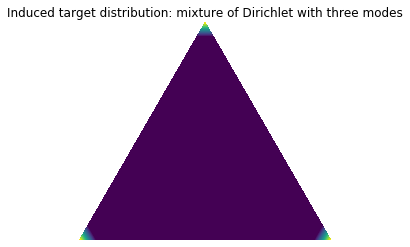

In [9]:
#We use 10,1,1 instead of 101,1,1 for visualization purpose?
dist = [torch.distributions.Dirichlet(torch.tensor(x)) for x in ([101.,1.,1.], 
                                                                 [1.,101.,1.], 
                                                                 [1.,1.,101.])]
plot.plot_dirichlet_simplex(dist)
plt.title("Induced target distribution: mixture of Dirichlet with three modes")
plt.show()

In [10]:
#What are the values at point (0,0)?
x = torch.tensor([0.0,0.0]).reshape(1,-1)
alph_out_fwd = model_fwd(x)['concentrations']
alph_out_rev = model_rev(x)['concentrations']

print("Value of the 'forward' and 'reverse' networks for the input : {}\n forward: {}\n reverse {}".format(x.tolist(), 
                                                                                                  alph_out_fwd.detach().tolist(),
                                                                                                  alph_out_rev.detach().tolist()))


Value of the 'forward' and 'reverse' networks for the input : [[0.0, 0.0]]
 forward: [[0.23818251490592957, 0.2192361056804657, 0.24213343858718872]]
 reverse [[30.742694854736328, 6.299171447753906, 23.496644973754883]]


For $f^{reverse}(x;\theta)$ we experimentally observe relatively sharp outputs that are well-balanced, whereas $f^{forward}(x;\theta)$ consists in three parameters close to $0$ which would yield a distribution spread accross the three corners of a simplex. 

To further support this point, we present a heatmap of the pdf of $p(\mu|f^{reverse}(x;\theta))$ and $p(\mu|f^{forward}(x;\theta))$. Rather than considering $x =(0,0)$, we generate a noise (for visualization purpose) by taking $x \in B(0;\epsilon)$ as $\int_{B(0;\epsilon)} p(\mu|f(x;\theta))dx \approx p(\mu|f(0;\theta))$.


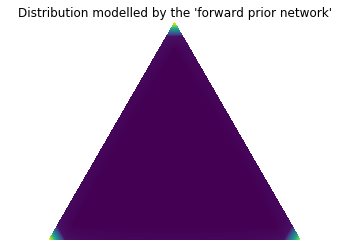

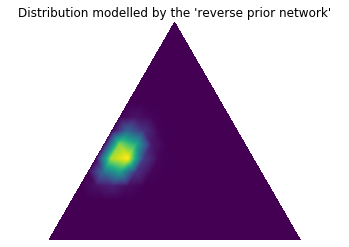

In [12]:
#=================================
# Grid
#=================================
possible_vals = np.linspace(-0.05, 0.05, 81)
x_vals, y_vals = np.meshgrid(possible_vals, possible_vals)
grid_inputs = torch.tensor(np.stack((x_vals.flatten(), y_vals.flatten()), axis=1), dtype=torch.float32)
#print("FORWARD")
alph_out = model_fwd(grid_inputs)['concentrations']
alph_out = alph_out.detach()
mixture = [torch.distributions.Dirichlet(alph_out[i]) for i in range(len(alph_out))]
plot.plot_dirichlet_simplex(mixture, nlevels=1000)
plt.title("Distribution modelled by the 'forward prior network'")
plt.show()

#print("REVERSE")
alph_out = model_rev(grid_inputs)['concentrations']
alph_out = alph_out.detach()
mixture = [torch.distributions.Dirichlet(alph_out[i]) for i in range(len(alph_out))]
plot.plot_dirichlet_simplex(mixture, nlevels=1000)
plt.title("Distribution modelled by the 'reverse prior network'")
plt.show()


#### Conclusion
Prior networks' behaviors strongly rely on the design choice that is the choice of the KL or reverse KL objective as a training objective. 
* When the dataset does not present class overlap, the two objectives are (experimentally) equivalent
* When the dataset presents, the forward KL objective forces the distribution modelled by the network to spread its mass accross the the corners of the simplex, whereas the reverse kl objective yield a distribution centered around the centered of the simplex, implying a model highly uncertain about its decision